In [23]:
# get h5 file 'posterior_samples.h5'
import numpy as np
import h5py
import matplotlib.pyplot as plt
import corner

# read h5 file
f = h5py.File('posterior_samples.h5', 'r')

In [11]:
events = f['Combined_PHM_lowSecondarySpin']['posterior_samples']

In [21]:
events['theta_jn']

array([0.70208651, 2.17792845, 0.42330785, ..., 2.30761784, 0.78985343,
       1.11592166])

In [26]:
m10 = np.array(events['mass_1_source'])
m20 = np.array(events['mass_2_source'])
chirp_mass0 = ( (m10*m20)**(3/5) )/( (m10+m20)**(1/5) )
D0 = np.array(events['luminosity_distance'])
theta_jn0 = np.arccos(np.array(events['theta_jn']))
mass_ratio0 = m20/m10

# find nan in theta_jn
idx = np.isnan(theta_jn0)
m10 = m10[~idx]
m20 = m20[~idx]
chirp_mass0 = chirp_mass0[~idx]
D0 = D0[~idx]
theta_jn0 = theta_jn0[~idx]
mass_ratio0 = mass_ratio0[~idx]

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_31423/1075654191.py:5: RuntimeWarning: invalid value encountered in arccos
  theta_jn0 = np.arccos(np.array(events['theta_jn']))


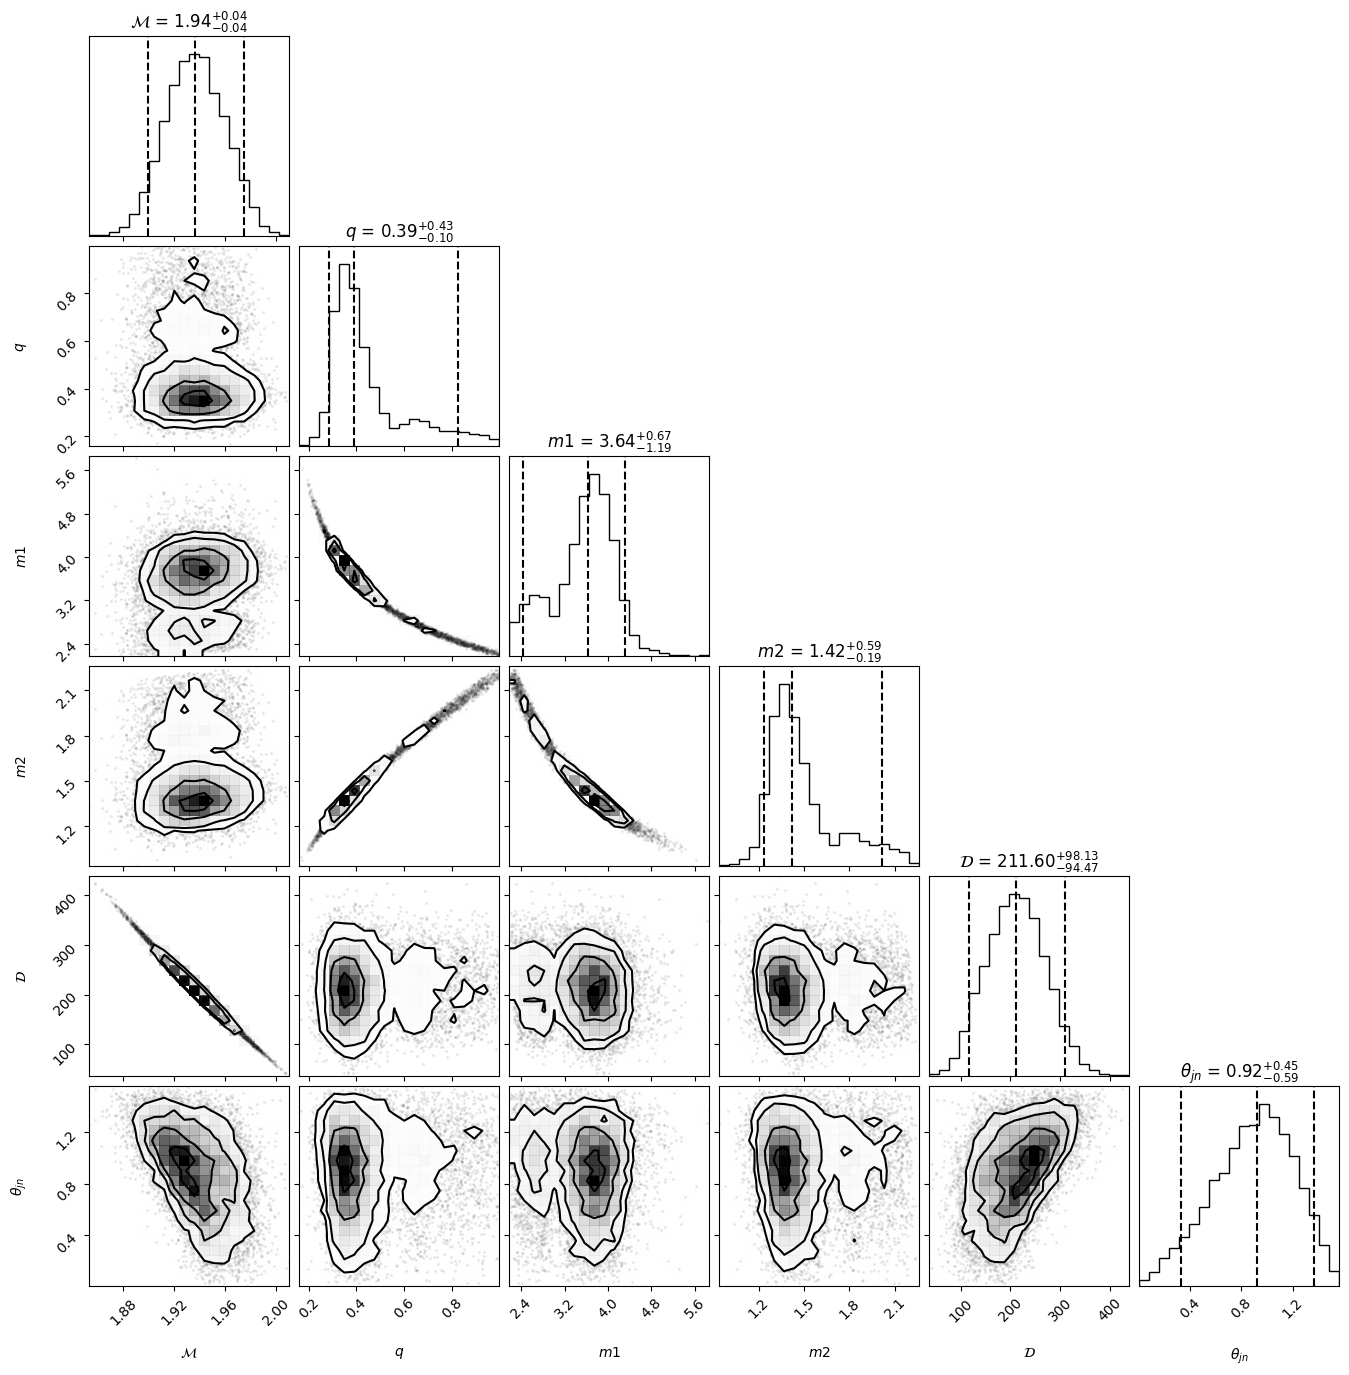

In [28]:
data0 = np.transpose(np.array([chirp_mass0,mass_ratio0,m10,m20,D0,theta_jn0]))
figure = corner.corner(data0, labels=[r"$\mathcal{M}$", r"$q$",r"$m1$", r"$m2$", r"$\mathcal{D}$", r"$\theta_{jn}$"],
                       quantiles=[0.05, 0.5, 0.95],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [32]:
# convert redshift to luminosity distance with astropy
from astropy.cosmology import Planck18
from astropy import units as u
from ler.rates import LeR

ler = LeR(verbose=False)

zs=3
Planck18.luminosity_distance(zs).to(u.Mpc).value

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:162: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:160: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)


26016.015955798568

In [34]:
ler.Dl_to_z(np.array([211]))

array([0.04754487])